In [1]:
!unzip "/content/Classified_images.zip"

Archive:  /content/Classified_images.zip
   creating: Classified_images/akiec/
   creating: Classified_images/akiec/test/
  inflating: Classified_images/akiec/test/ISIC_0024329.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024418.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024463.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024511.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024522.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024539.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024562.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024575.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024646.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024654.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024707.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024771.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024913.jpg  
  inflating: Classified_images/akiec/test/ISIC_0024923.jpg  
  inflating: Classified_

### **Importing Required Libraries for Model and Data Handling**
This code imports necessary dependencies, including PyTorch, torchvision, and utilities for handling datasets, model training, mixed precision, and evaluation.

In [ ]:
#Import dependencies
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
import torchvision
import warnings


### **Device Configuration and Training Setup**
This code configures the device for model training (using GPU if available), sets environment variables for memory management, suppresses future warnings, and prepares mixed precision and gradient accumulation for efficient training.

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set environment variable to avoid memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Mixed Precision Training Setup
scaler = GradScaler()

# Gradient Accumulation Setup
accumulation_steps = 4


Using device: cuda



### **Data Augmentation and Transformation for Custom Dataset**
This code defines a set of image transformations to augment and normalize the dataset, which includes resizing, random rotations, flips, color adjustments, random cropping, affine transformations, and normalization for use in training a deep learning model.

In [ ]:
# Data Augmentation and Transformation for your custom dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### **Defining Classes and Class Indices**
This code creates a list of class labels for the dataset and generates a dictionary (class_to_idx) that maps each class name to a corresponding index, which will be useful for labeling and organizing the dataset.

In [ ]:
# Classes (labels) in your dataset
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'vasc', 'df']
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

In [ ]:
# Path to the root directory of the dataset
dataset_dir = '/content/Classified_images'


### **Custom Dataset Class for Image Loading**
This code defines a CustomDataset class to load images from specific directories based on the dataset split (train or test) and applies any provided transformations to the images. The dataset assumes images are organized by class and split, and the labels are mapped using the class_to_idx dictionary.

In [ ]:
# Custom dataset class to load images from a specific split (train or test)
class CustomDataset(Dataset):
    def __init__(self, dataset_dir, class_name, split='train', transform=None):
        self.dataset_dir = dataset_dir
        self.class_name = class_name
        self.split = split  # 'train' or 'test'
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Define path for the specified split
        split_dir = os.path.join(dataset_dir, class_name, split)

        # Check if the directory exists
        if not os.path.exists(split_dir):
            raise FileNotFoundError(f"{split.capitalize()} directory not found: {split_dir}")

        # Add images from the split directory
        for file_name in os.listdir(split_dir):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(split_dir, file_name))
                self.labels.append(class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


### **Function to Load and Combine Datasets for Each Class and Split**
This function loads images from a specified directory for each class and split (train/test), creates a CustomDataset for each class, and then combines them into unified datasets for training and testing. It also prints the count of images in each class for both train and test datasets.

In [ ]:
# Function to load datasets for each class and split into train and test
def load_datasets(dataset_dir, classes, transform):
    train_datasets = []
    test_datasets = []
    train_counts = {}
    test_counts = {}
    for class_name in classes:
        print(f"Loading train dataset for class: {class_name}")
        train_dataset = CustomDataset(dataset_dir, class_name, split='train', transform=transform)
        train_datasets.append(train_dataset)
        train_counts[class_name] = len(train_dataset)

        print(f"Loading test dataset for class: {class_name}")
        test_dataset = CustomDataset(dataset_dir, class_name, split='test', transform=transform)
        test_datasets.append(test_dataset)
        test_counts[class_name] = len(test_dataset)

    # Combine all class-specific datasets into unified train and test datasets
    combined_train_dataset = ConcatDataset(train_datasets)
    combined_test_dataset = ConcatDataset(test_datasets)

    # Print counts
    print("\nTraining dataset counts per class:")
    for class_name, count in train_counts.items():
        print(f"{class_name}: {count}")

    print("\nTesting dataset counts per class:")
    for class_name, count in test_counts.items():
        print(f"{class_name}: {count}")

    return combined_train_dataset, combined_test_dataset

In [ ]:
# Load and combine datasets
combined_train_dataset, combined_test_dataset = load_datasets(dataset_dir, classes, transform)

Loading train dataset for class: akiec
Loading test dataset for class: akiec
Loading train dataset for class: bcc
Loading test dataset for class: bcc
Loading train dataset for class: bkl
Loading test dataset for class: bkl
Loading train dataset for class: mel
Loading test dataset for class: mel
Loading train dataset for class: nv
Loading test dataset for class: nv
Loading train dataset for class: vasc
Loading test dataset for class: vasc
Loading train dataset for class: df
Loading test dataset for class: df

Training dataset counts per class:
akiec: 654
bcc: 500
bkl: 500
mel: 500
nv: 500
vasc: 568
df: 537

Testing dataset counts per class:
akiec: 150
bcc: 150
bkl: 150
mel: 150
nv: 150
vasc: 142
df: 115


### **DataLoader Creation for Combined Datasets**
  This code creates DataLoader objects for the training and test datasets,ensuring batch processing, shuffling, and handling of incomplete batches for training while keeping all test samples intact.





In [ ]:
# Create DataLoader for combined datasets

train_loader = DataLoader(
    combined_train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)
# Keep only complete batches for training

test_loader = DataLoader(
    combined_test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)
 # Keep all test samples

### **ResNet Feature Extractor Class**
This class extracts features from a pre-trained ResNet model by removing the final fully connected layer, allowing the use of convolutional layers for feature extraction.

In [ ]:

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatureExtractor, self).__init__()
        # Take all layers except the final FC
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            original_model.layer3,
            original_model.layer4
        )

    def forward(self, x):
        x = self.features(x)  # shape: (B,512,7,7) for ResNet18 with input 224x224
        return x

### **Transformer Encoder Model Class**

This class implements a transformer encoder model for classification tasks, utilizing multi-head attention, dropout, and mean pooling to process input data and generate class predictions.

In [ ]:

class TransformerEncoderModel(nn.Module):
    def __init__(self, embed_dim=96, num_heads=8, num_layers=6, num_classes=7, dropout=0.1):
        super(TransformerEncoderModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # x shape: (B, C, H, W) -> (B, C, H*W)
        B, C, H, W = x.size()
        x = x.view(B, C, H * W).permute(2, 0, 1)  # (H*W, B, C)

        # Transformer Encoder expects input shape: (S, N, E)
        x = self.transformer_encoder(x)  # (S, B, E)

        # Mean pooling over the sequence length (S)
        x = x.mean(dim=0)  # (B, E)

        x = self.dropout(x)
        x = self.classifier(x)  # (B, num_classes)
        return x

### **Hybrid Model Class**
This class defines a hybrid model that combines feature extraction, transformer encoding, and a projection layer to process and classify input data, leveraging both convolutional and attention-based mechanisms.

In [ ]:
# Define the Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, feature_extractor, transformer_encoder, projection):
        super(HybridModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.transformer_encoder = transformer_encoder
        self.projection = projection
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        features = self.feature_extractor(x)                                   # (B, 512, 7, 7)
        features = self.dropout(features)
        B, C, H, W = features.size()

        #(B, 512, 7, 7) -> (B, 96, 7, 7)
        features = features.view(B, C, H * W).permute(0, 2, 1)                 # (B, 49, 512)
        features = self.projection(features)                                   # (B, 49, 96)
        features = features.permute(0, 2, 1).view(B, 96, H, W)                 # (B, 96, 7, 7)


        outputs = self.transformer_encoder(features)                           # (B, num_classes)

        return outputs

### **Loading and Fine-Tuning Pretrained ResNet Model**
This code loads a pretrained ResNet-18 model, extracts its feature layers, moves it to the device, sets it to training mode, and unlocks the parameters for fine-tuning by enabling gradient computation.

In [ ]:
# Load Pretrained ResNet
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
feature_extractor = ResNetFeatureExtractor(resnet)
feature_extractor.to(device)
feature_extractor.train()

# Unlock ResNet parameters for fine-tuning
for param in feature_extractor.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


### **Creating and Preparing the Transformer Encoder Model**
This code initializes the Transformer Encoder model, sets it to the specified configuration (embedding dimension, number of heads, layers, and classes), moves it to the device, and sets it to training mode.

In [ ]:
# Create the Transformer Encoder Model
transformer_encoder = TransformerEncoderModel(embed_dim=96, num_heads=8, num_layers=6, num_classes=len(classes))
transformer_encoder.to(device)
transformer_encoder.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerEncoderModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=96, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### **Initializing the Hybrid Model**
This code creates a linear projection layer to map the output features from ResNet (512 channels) to the Transformer embedding dimension (96), and then initializes the Hybrid Model by combining the feature extractor (ResNet), transformer encoder, and the projection layer. The model is then moved to the specified device.

In [ ]:
# Create a linear projection to map ResNet features to Transformer embedding dimension
embed_dim = 96
projection = nn.Linear(512, embed_dim)
projection.to(device)

# Initialize the Hybrid Model
model = HybridModel(feature_extractor, transformer_encoder, projection)
model.to(device)


HybridModel(
  (feature_extractor): ResNetFeatureExtractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b

### **Class Weights for Cross-Entropy Loss**
This code assigns class-specific weights to the CrossEntropyLoss function to handle class imbalance during training.

In [ ]:
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

### **Adam Optimizer for Model Training**
This code sets up the Adam optimizer with a learning rate of 0.0001 and weight decay for regularization.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

### **Training Loop with Early Stopping**
This code implements the training loop with mixed precision, accuracy calculation, and early stopping to halt training when the model performance doesn't improve for a specified number of epochs (patience).

In [ ]:

# Early Stopping
best_accuracy = 0
patience = 5
epochs_without_improvement = 0

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Mixed Precision Forward Pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Normalize loss

        # Mixed Precision Backward Pass and Optimizer Step
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Early Stopping
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping after {epoch + 1} epochs")
        break

Epoch [1/60], Loss: 1.8237, Accuracy: 22.71%
Epoch [2/60], Loss: 1.2761, Accuracy: 44.18%
Epoch [3/60], Loss: 0.9755, Accuracy: 55.17%
Epoch [4/60], Loss: 0.8034, Accuracy: 63.17%
Epoch [5/60], Loss: 0.6934, Accuracy: 68.18%
Epoch [6/60], Loss: 0.6167, Accuracy: 71.63%
Epoch [7/60], Loss: 0.5671, Accuracy: 74.25%
Epoch [8/60], Loss: 0.5316, Accuracy: 75.35%
Epoch [9/60], Loss: 0.4868, Accuracy: 77.40%
Epoch [10/60], Loss: 0.4569, Accuracy: 79.42%
Epoch [11/60], Loss: 0.4313, Accuracy: 79.96%
Epoch [12/60], Loss: 0.4167, Accuracy: 81.22%
Epoch [13/60], Loss: 0.4008, Accuracy: 82.03%
Epoch [14/60], Loss: 0.3735, Accuracy: 83.19%
Epoch [15/60], Loss: 0.3403, Accuracy: 84.54%
Epoch [16/60], Loss: 0.3410, Accuracy: 84.21%
Epoch [17/60], Loss: 0.2940, Accuracy: 86.83%
Epoch [18/60], Loss: 0.2868, Accuracy: 87.31%
Epoch [19/60], Loss: 0.2954, Accuracy: 87.31%
Epoch [20/60], Loss: 0.2665, Accuracy: 88.44%
Epoch [21/60], Loss: 0.2697, Accuracy: 87.85%
Epoch [22/60], Loss: 0.2439, Accuracy: 89.7

### **Model Evaluation on Test Set**
This code sets the model to evaluation mode, calculates the loss and accuracy on the test set, and prints the final test accuracy.

In [ ]:
# Set the model to evaluation mode
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate final accuracy on the test set
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.41%


Confusion Matrix:
[[149   0   1   0   0   0   0]
 [  0 148   1   0   0   0   1]
 [  2   0 143   1   3   1   0]
 [  0   0   3 145   2   0   0]
 [  0   0   0   5 145   0   0]
 [  0   0   0   0   0 142   0]
 [  0   0   0   0   0   0 115]]


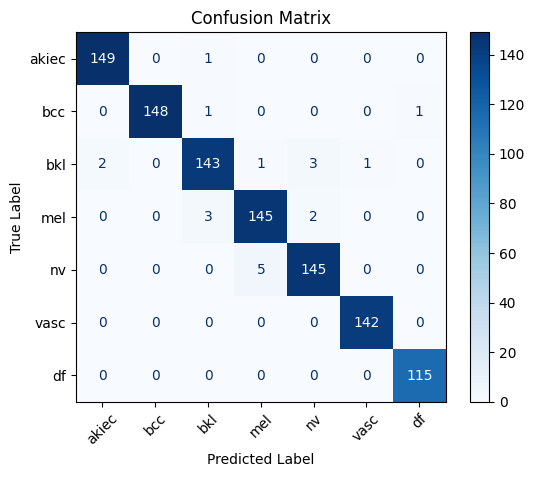

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

def plot_confusion_matrix(model, test_loader, classes, device):
    """
    Plot the confusion matrix for the model's predictions on the test dataset.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test dataset.
        classes: List of class names.
        device: Device to run the model (CPU or GPU).
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    # Concatenate all predictions and labels
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Call the function
plot_confusion_matrix(model, test_loader, classes, device)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
import torchvision.models as models
import warnings

# Set environment variable to avoid memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Augmentation and Transformation for your custom dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(224, padding=4),  # Add random cropping
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transform
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Classes (labels) in your dataset
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'vasc', 'df']
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

# Path to the root directory of the dataset
dataset_dir = '/content/Classified_images'  # Ensure this path is correct

# Custom dataset class to load images from a specific split (train or test)
class CustomDataset(Dataset):
    def __init__(self, dataset_dir, class_name, split='train', transform=None):
        self.dataset_dir = dataset_dir
        self.class_name = class_name
        self.split = split  # 'train' or 'test'
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Define path for the specified split
        split_dir = os.path.join(dataset_dir, class_name, split)

        # Check if the directory exists
        if not os.path.exists(split_dir):
            raise FileNotFoundError(f"{split.capitalize()} directory not found: {split_dir}")

        # Add images from the split directory
        for file_name in os.listdir(split_dir):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Handle different image formats
                self.image_paths.append(os.path.join(split_dir, file_name))
                self.labels.append(class_to_idx[class_name])  # Add the class index as label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations

        label = self.labels[idx]
        return image, label

# Function to load datasets for each class and split into train and test
def load_datasets(dataset_dir, classes, transform):
    train_datasets = []
    test_datasets = []
    train_counts = {}
    test_counts = {}
    for class_name in classes:
        print(f"Loading train dataset for class: {class_name}")
        train_dataset = CustomDataset(dataset_dir, class_name, split='train', transform=transform)
        train_datasets.append(train_dataset)
        train_counts[class_name] = len(train_dataset)

        print(f"Loading test dataset for class: {class_name}")
        test_dataset = CustomDataset(dataset_dir, class_name, split='test', transform=transform)
        test_datasets.append(test_dataset)
        test_counts[class_name] = len(test_dataset)

    # Combine all class-specific datasets into unified train and test datasets
    combined_train_dataset = ConcatDataset(train_datasets)
    combined_test_dataset = ConcatDataset(test_datasets)

    # Print counts
    print("\nTraining dataset counts per class:")
    for class_name, count in train_counts.items():
        print(f"{class_name}: {count}")

    print("\nTesting dataset counts per class:")
    for class_name, count in test_counts.items():
        print(f"{class_name}: {count}")

    return combined_train_dataset, combined_test_dataset

# Load and combine datasets
combined_train_dataset, combined_test_dataset = load_datasets(dataset_dir, classes, transform)

# Create DataLoader for combined datasets
train_loader = DataLoader(
    combined_train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True  # Drop the last incomplete batch to avoid shape issues
)

test_loader = DataLoader(
    combined_test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False  # Keep all test samples
)

# Define the Swin Transformer Model
class SwinTransformerModel(nn.Module):
    def __init__(self, num_classes=7):
        super(SwinTransformerModel, self).__init__()
        # Load Swin Transformer pretrained model
        self.swin_transformer = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)

        # Modify the head for classification
        in_features = self.swin_transformer.head.in_features  # Extract input features of original head
        self.swin_transformer.head = nn.Identity()  # Remove original head

        # Add a new classifier
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Forward pass through Swin Transformer
        x = self.swin_transformer(x)  # Output: (B, in_features)
        x = self.classifier(x)  # Final output: (B, num_classes)
        return x

# Create the Swin Transformer Model
model = SwinTransformerModel(num_classes=len(classes))
model.to(device)
model.train()

# Define loss function with class weights to handle class imbalance
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Mixed Precision Training Setup
scaler = GradScaler()  # For mixed precision training

# Training loop
num_epochs = 60
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Save the best model
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model.state_dict(), 'best_swin_model.pth')

# Testing loop
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate final accuracy
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Using device: cuda
Loading train dataset for class: akiec
Loading test dataset for class: akiec
Loading train dataset for class: bcc
Loading test dataset for class: bcc
Loading train dataset for class: bkl
Loading test dataset for class: bkl
Loading train dataset for class: mel
Loading test dataset for class: mel
Loading train dataset for class: nv
Loading test dataset for class: nv
Loading train dataset for class: vasc
Loading test dataset for class: vasc
Loading train dataset for class: df
Loading test dataset for class: df

Training dataset counts per class:
akiec: 654
bcc: 500
bkl: 500
mel: 500
nv: 500
vasc: 568
df: 537

Testing dataset counts per class:
akiec: 150
bcc: 150
bkl: 150
mel: 150
nv: 150
vasc: 142
df: 115


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 169MB/s] 


Epoch [1/60], Loss: 67.9494, Accuracy: 44.96%
Epoch [2/60], Loss: 39.8371, Accuracy: 67.03%
Epoch [3/60], Loss: 32.1161, Accuracy: 73.52%
Epoch [4/60], Loss: 27.3446, Accuracy: 76.78%
Epoch [5/60], Loss: 23.9871, Accuracy: 79.85%
Epoch [6/60], Loss: 21.4406, Accuracy: 82.11%
Epoch [7/60], Loss: 19.0242, Accuracy: 83.67%
Epoch [8/60], Loss: 18.3075, Accuracy: 84.38%
Epoch [9/60], Loss: 16.6265, Accuracy: 85.51%
Epoch [10/60], Loss: 15.4963, Accuracy: 86.56%
Epoch [11/60], Loss: 14.3226, Accuracy: 87.15%
Epoch [12/60], Loss: 13.7786, Accuracy: 88.28%
Epoch [13/60], Loss: 11.4160, Accuracy: 90.17%
Epoch [14/60], Loss: 11.4256, Accuracy: 90.11%
Epoch [15/60], Loss: 10.4894, Accuracy: 90.89%
Epoch [16/60], Loss: 10.1433, Accuracy: 91.14%
Epoch [17/60], Loss: 8.4236, Accuracy: 92.62%
Epoch [18/60], Loss: 8.3186, Accuracy: 92.73%
Epoch [19/60], Loss: 9.4644, Accuracy: 91.95%
Epoch [20/60], Loss: 9.0349, Accuracy: 92.38%
Epoch [21/60], Loss: 8.2901, Accuracy: 93.10%
Epoch [22/60], Loss: 7.0480

In [3]:
# Testing loop with loss calculation
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
test_loss = 0.0  # Initialize test loss

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)  # Use the same criterion defined during training
        test_loss += loss.item()  # Accumulate test loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate final accuracy and average test loss
test_accuracy = 100 * test_correct / test_total
average_test_loss = test_loss / len(test_loader)  # Average loss per batch

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {average_test_loss:.4f}")


Test Accuracy: 99.50%
Test Loss: 0.0140
